In [75]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import os

# Configurar matplotlib para VSCode
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Paths absolutos
BASE_DIR = "/Users/diego/Documents/tesis_standalone/tesis_unet_2"
MODEL_PATHS = {
    'last12': f"{BASE_DIR}/logs/last12/test_results.h5",
    'unet3': f"{BASE_DIR}/logs/unet3/test_results.h5",
    'unet4': f"{BASE_DIR}/logs/unet4/test_results.h5"
}

In [76]:
def load_results(h5_path):
    """Carga resultados de un modelo"""
    with h5py.File(h5_path, 'r') as f:
        data = {
            'inputs': f['inputs'][:],
            'targets': f['targets'][:],
            'predictions': f['predictions'][:],
            'metrics': {
                'mse': f.attrs['metric_mse'],
                'csi': f.attrs['metric_csi'],
                'far': f.attrs['metric_far'],
                'hss': f.attrs['metric_hss']
            },
            'model_type': f.attrs['model_type']
        }
    
    print(f"✅ {data['model_type']} - Secuencias: {data['inputs'].shape[0]}")
    print(f"   MSE: {data['metrics']['mse']:.4f}, CSI: {data['metrics']['csi']:.4f}")
    return data

# Cargar todos los modelos
results = {}
for name, path in MODEL_PATHS.items():
    if os.path.exists(path):
        results[name] = load_results(path)

✅ last12 - Secuencias: 29
   MSE: 0.0670, CSI: 0.0136
✅ unet3 - Secuencias: 29
   MSE: 0.0090, CSI: 0.1929
✅ unet4 - Secuencias: 29
   MSE: 0.0089, CSI: 0.1946


In [77]:
data.keys()

dict_keys(['inputs', 'targets', 'predictions', 'metrics', 'model_type'])

In [78]:
data['inputs']

array([[[[2.10590772e-02, 1.53368618e-02, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.35052763e-02, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [9.99543164e-03, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        

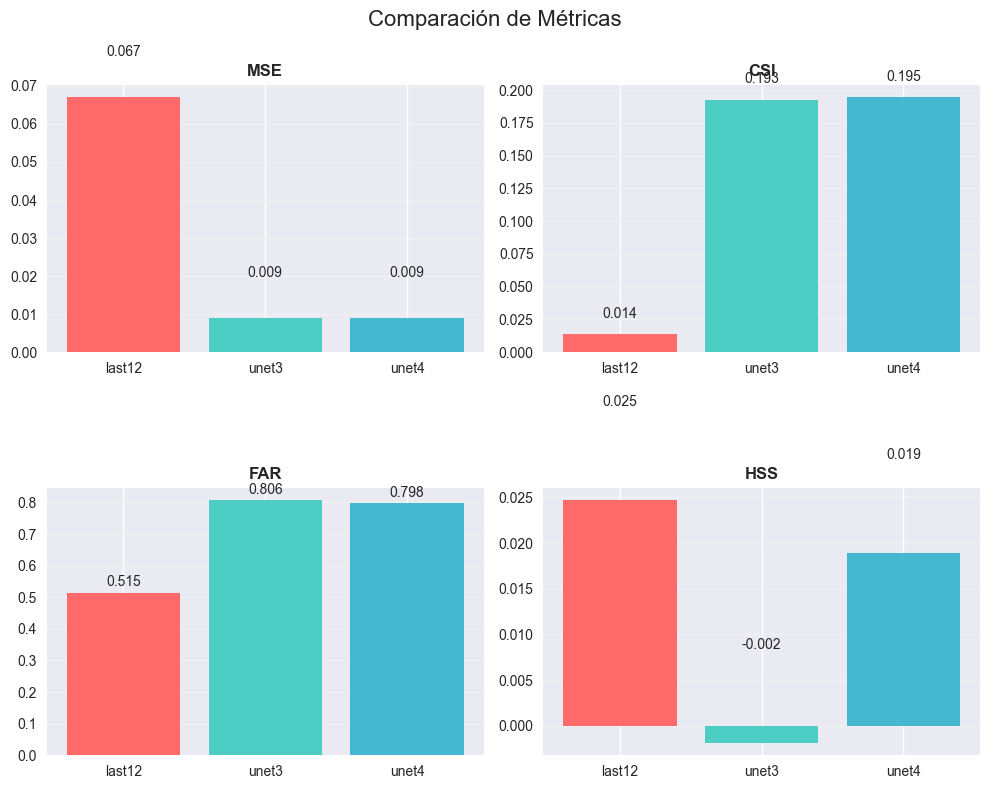

In [79]:
# Comparación de métricas
metrics = ['mse', 'csi', 'far', 'hss']
models = list(results.keys())

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    values = [results[m]['metrics'][metric] for m in models]
    bars = axes[idx].bar(models, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    
    # Valores en las barras
    for bar, val in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{val:.3f}', ha='center', va='bottom')
    
    axes[idx].set_title(metric.upper(), fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas', fontsize=16)
plt.tight_layout()
plt.show()

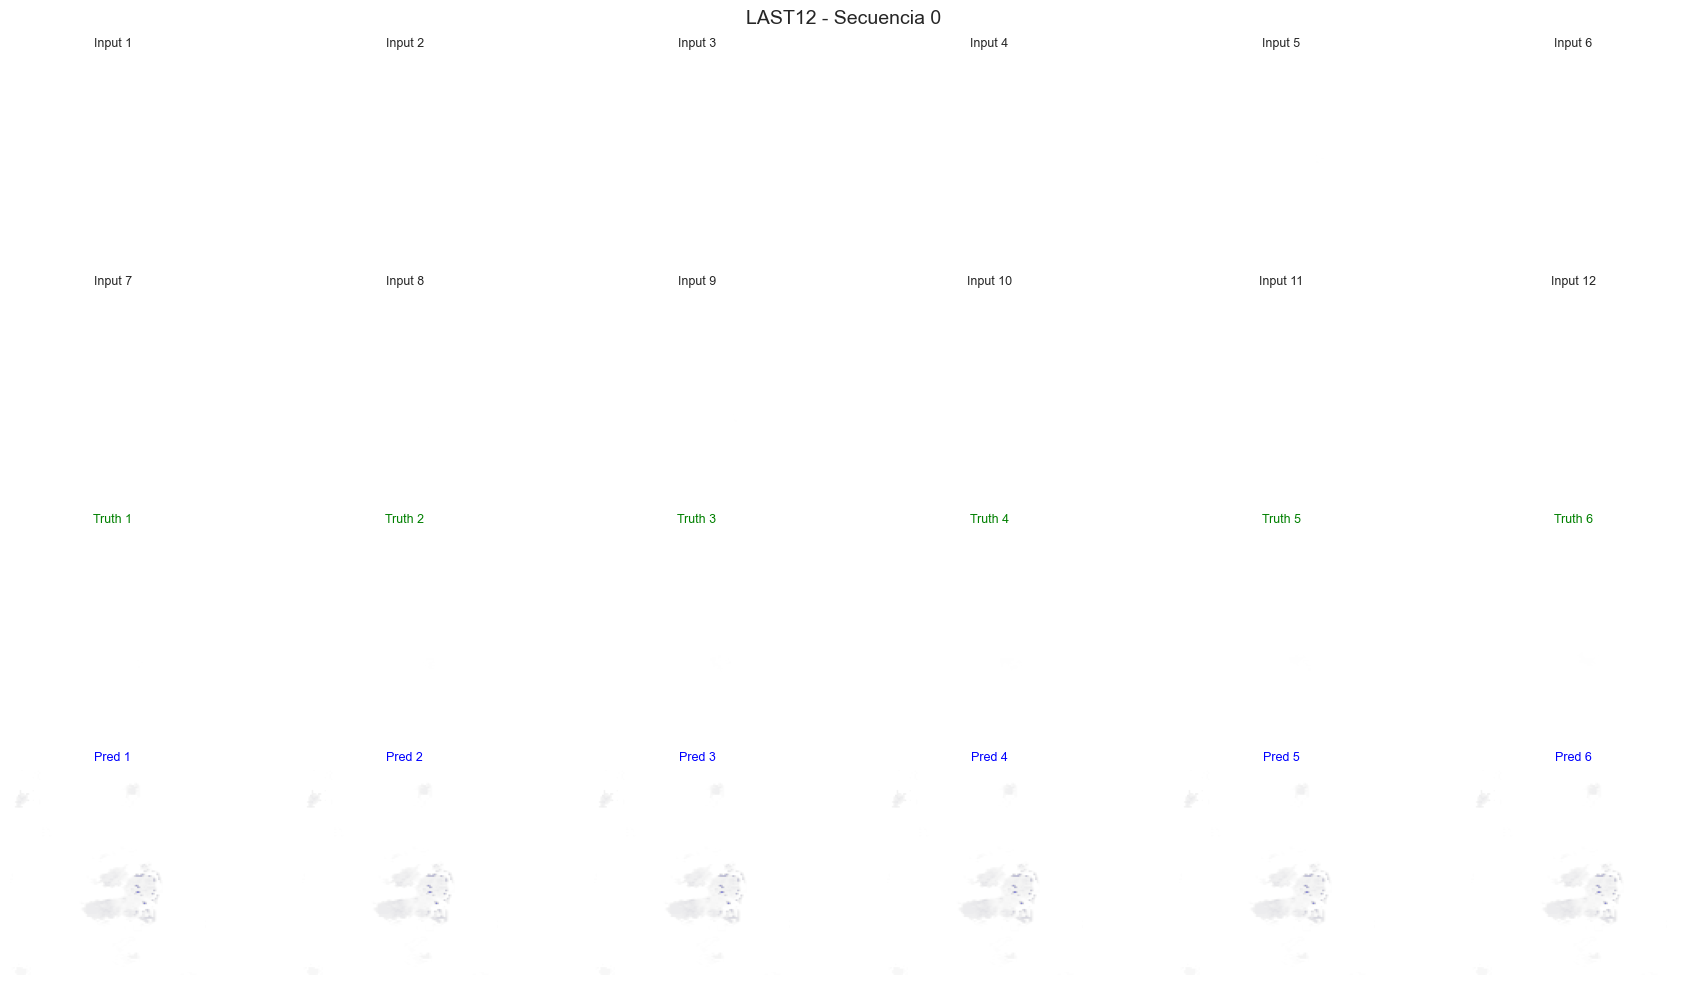

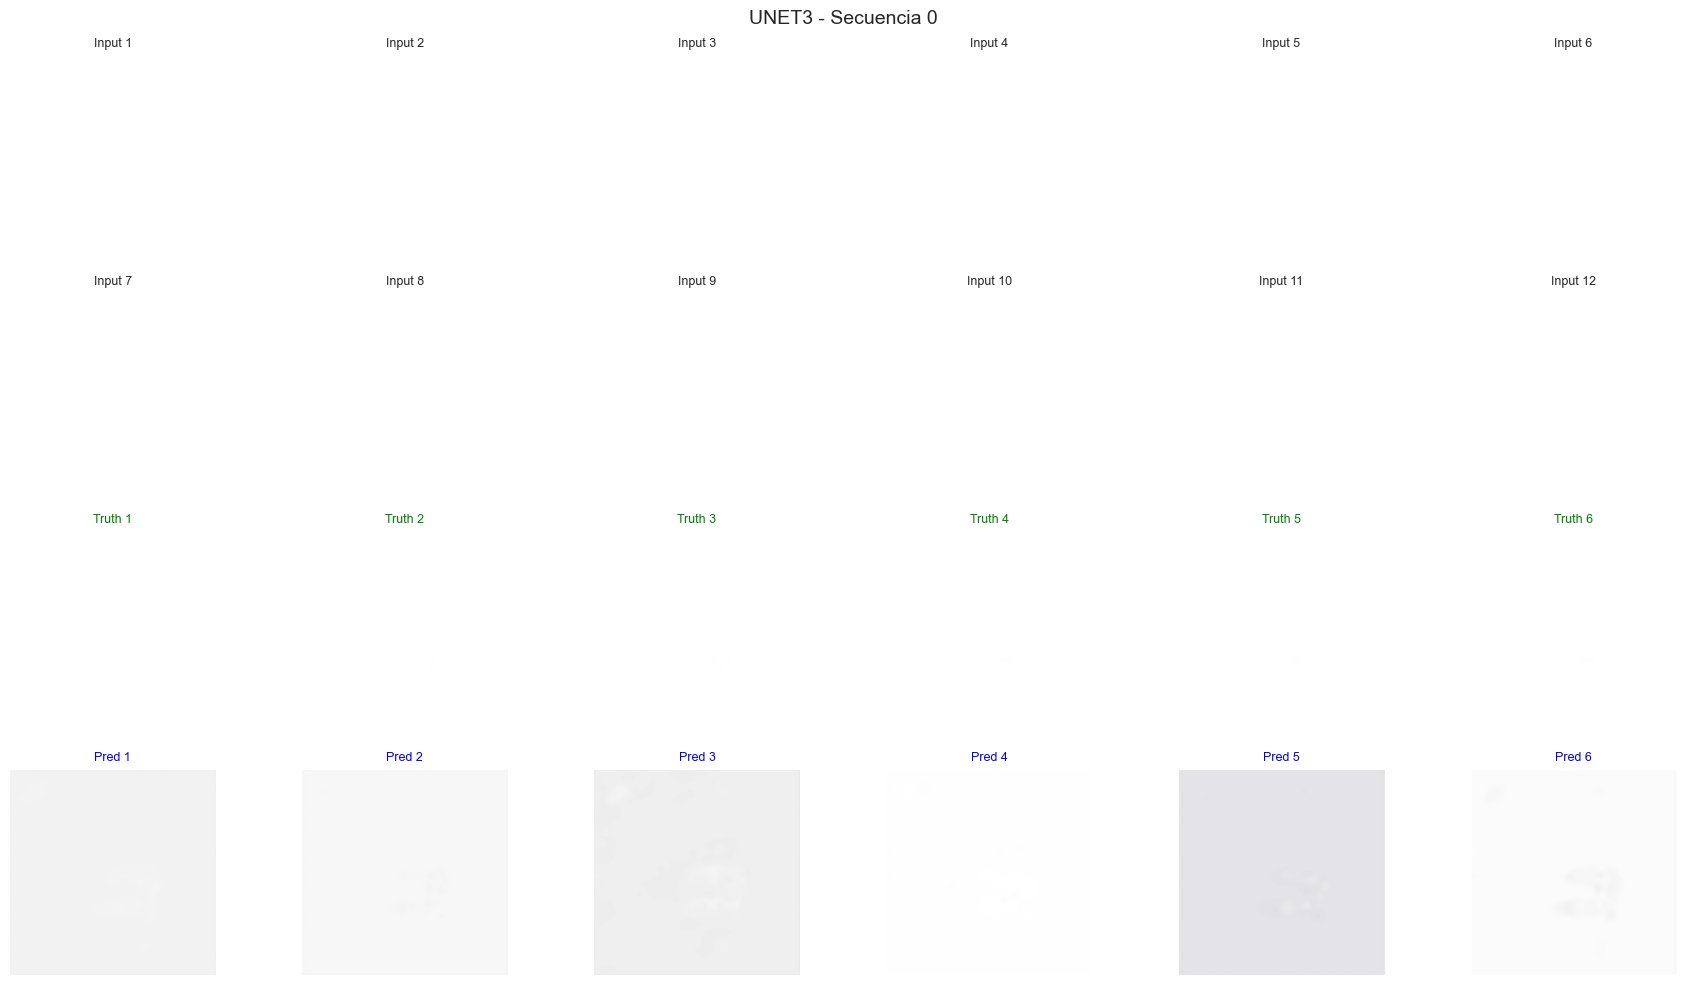

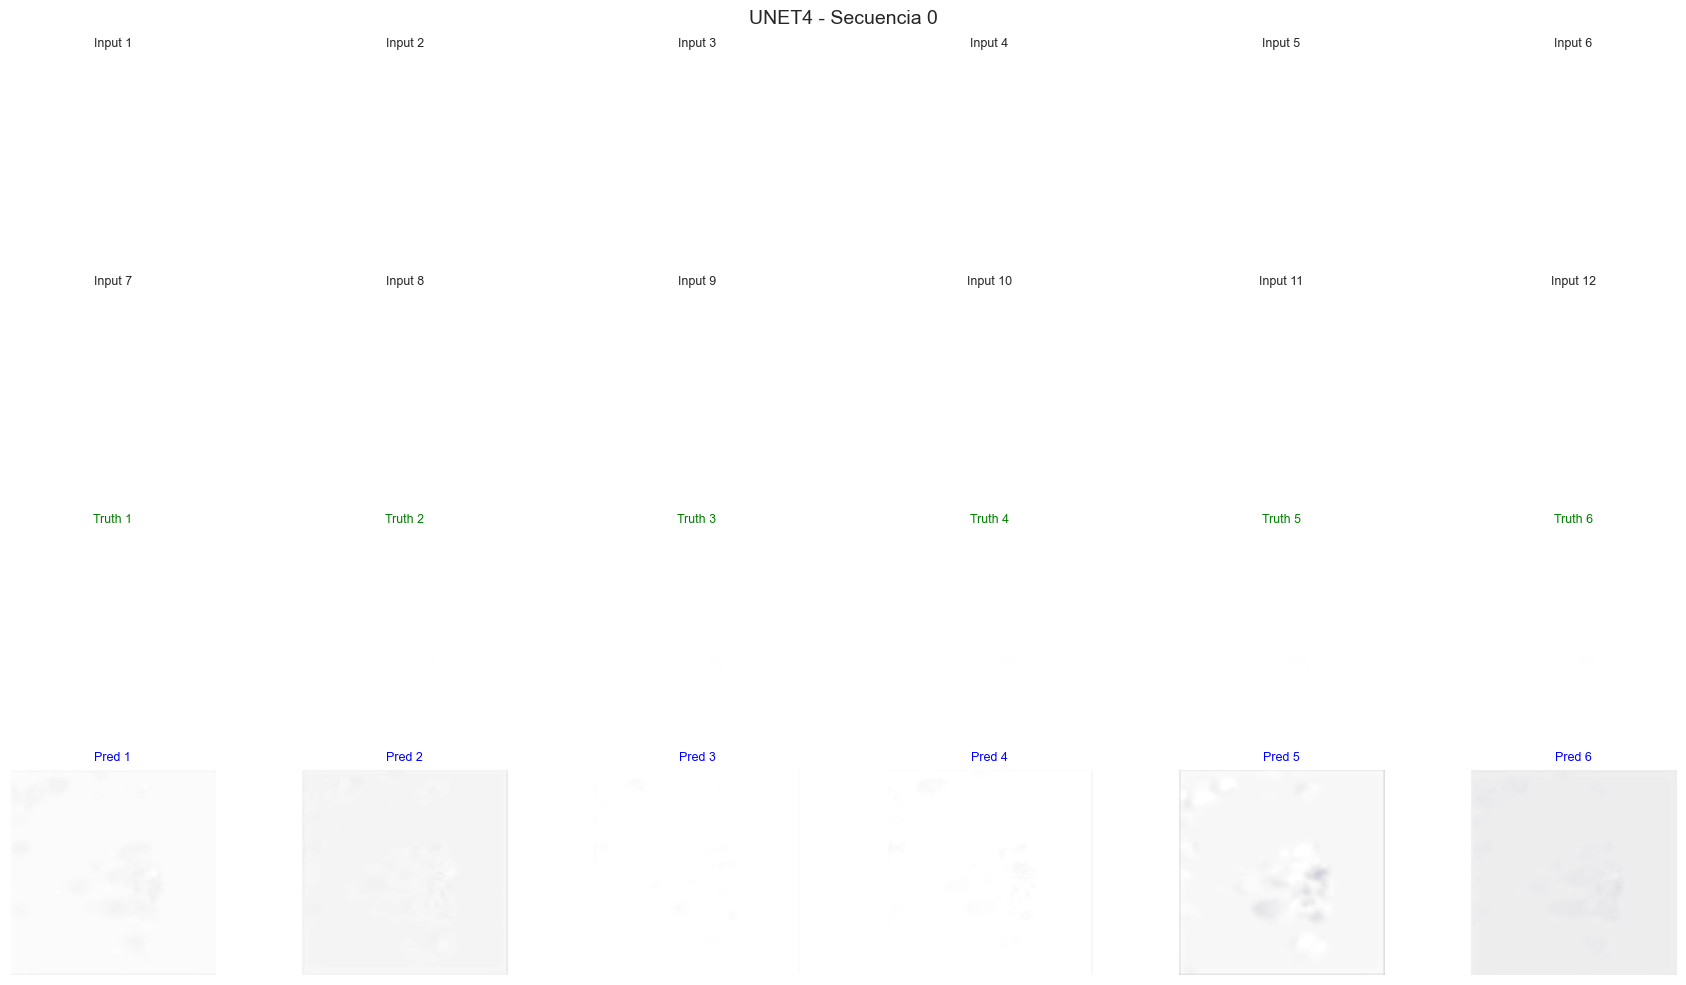

In [80]:
def show_prediction(model_name, seq_idx=0):
    """Muestra inputs, targets y predicciones para una secuencia"""
    data = results[model_name]
    
    # Datos
    inputs = data['inputs'][seq_idx]
    targets = data['targets'][seq_idx]
    preds = data['predictions'][seq_idx]
    
    # Crear figura
    fig = plt.figure(figsize=(18, 10))
    
    # Colormap personalizado
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    # Inputs (2 filas de 6)
    for i in range(12):
        plt.subplot(4, 6, i+1)
        plt.imshow(inputs[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Input {i+1}', fontsize=9)
        plt.axis('off')
    
    # Ground truth
    for i in range(6):
        plt.subplot(4, 6, 13+i)
        plt.imshow(targets[i]*1, cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Truth {i+1}', fontsize=9, color='green')
        plt.axis('off')
    
    # Predicciones
    for i in range(6):
        plt.subplot(4, 6, 19+i)
        plt.imshow(preds[i], cmap=cmap, vmin=0, vmax=100)
        plt.title(f'Pred {i+1}', fontsize=9, color='blue')
        plt.axis('off')
    
    plt.suptitle(f'{model_name.upper()} - Secuencia {seq_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualizar una secuencia de cada modelo
for model in results.keys():
    show_prediction(model, seq_idx=0)

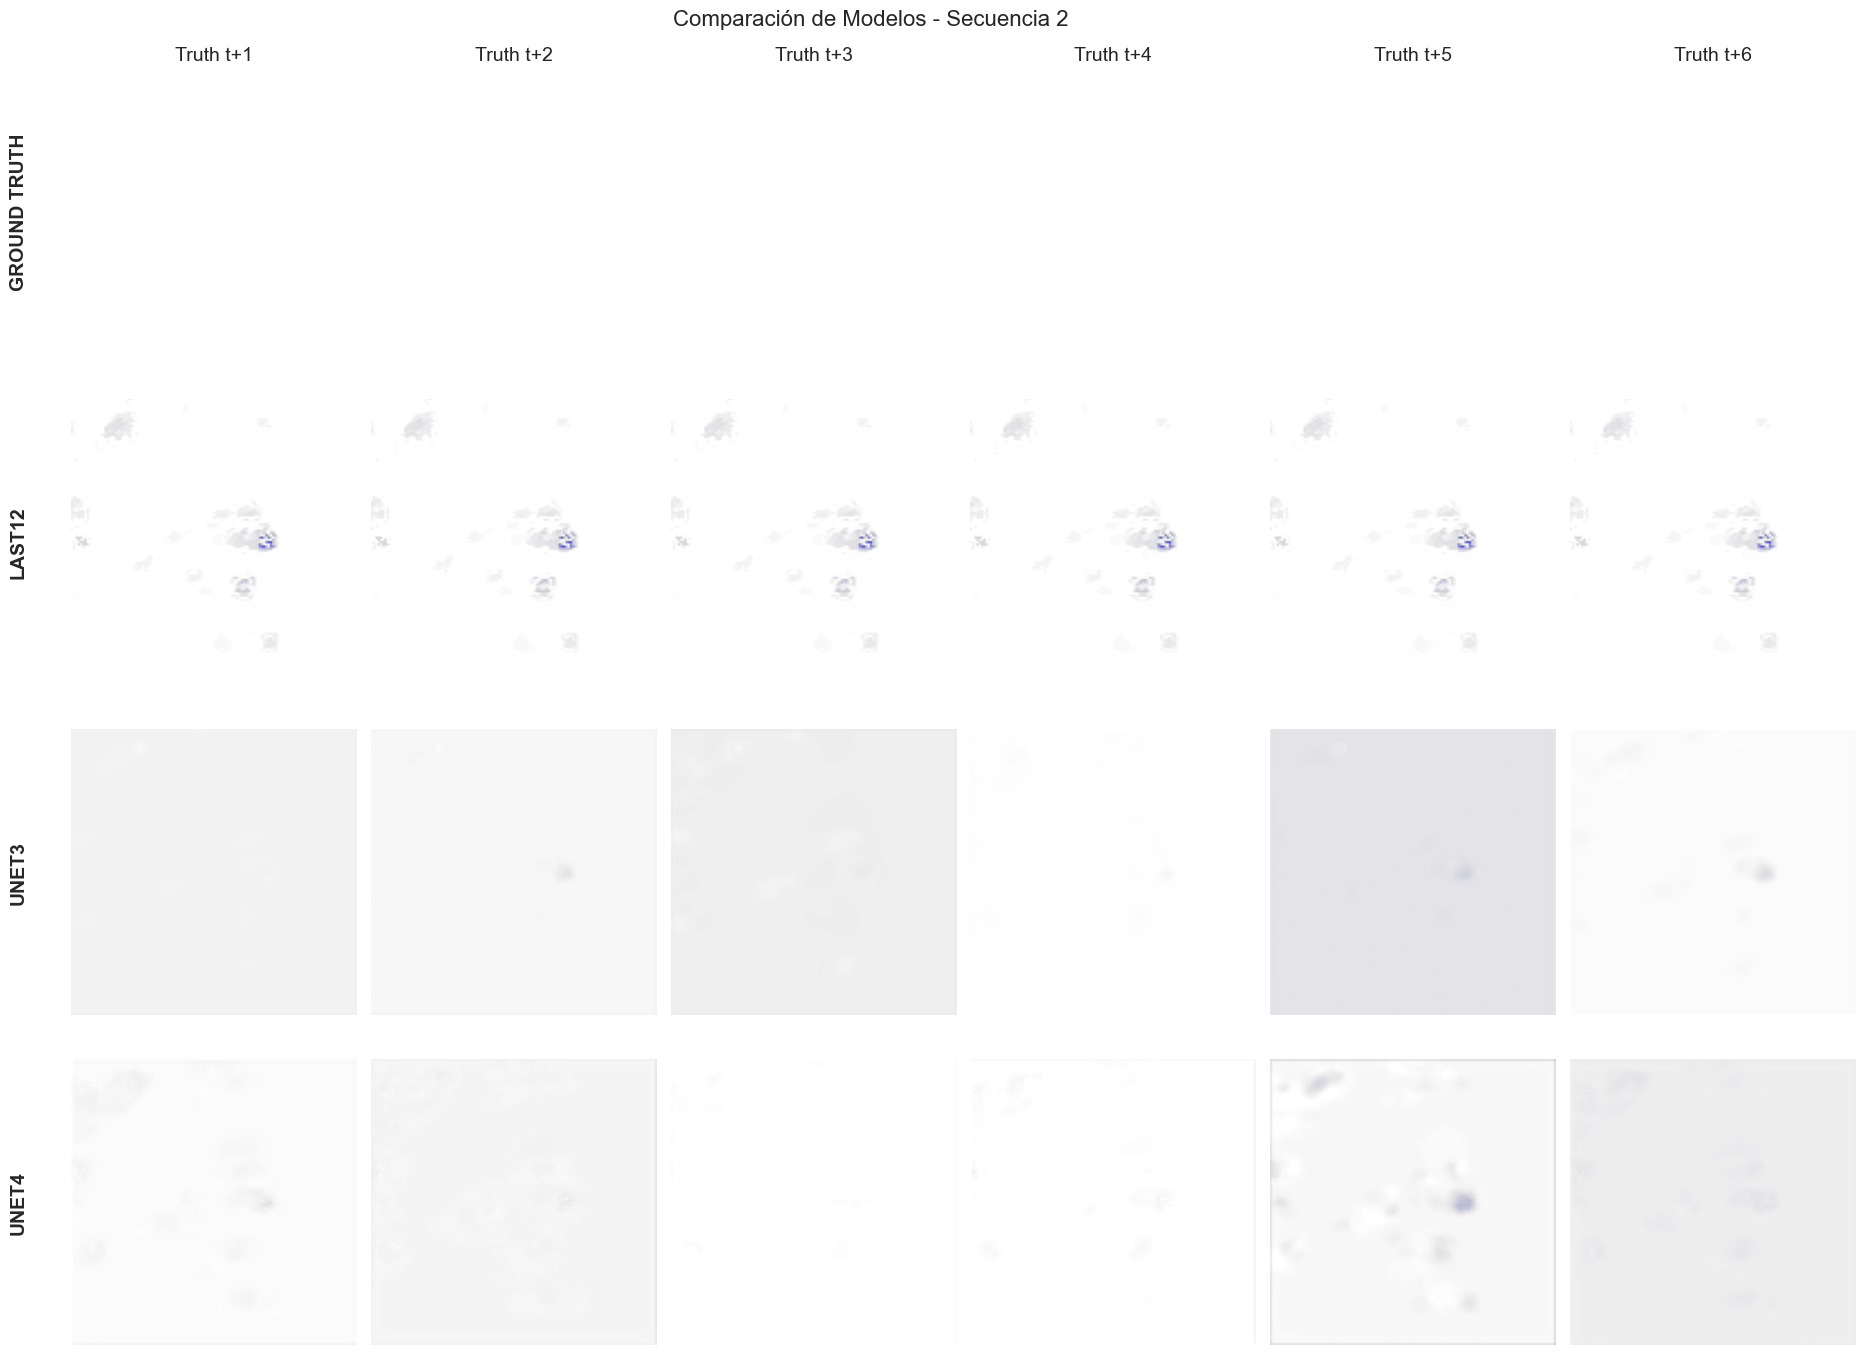

In [81]:
def compare_models(seq_idx=0):
    """Compara predicciones de todos los modelos"""
    fig, axes = plt.subplots(4, 6, figsize=(20, 14))  # Aumentar el tamaño
    
    # Colormap
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    # Ground truth (primera fila)
    targets = results[list(results.keys())[0]]['targets'][seq_idx]
    for i in range(6):
        axes[0, i].imshow(targets[i], cmap=cmap, vmin=0, vmax=100)
        axes[0, i].set_title(f'Truth t+{i+1}', fontsize=14)
        axes[0, i].axis('off')
    
    # Etiqueta para la fila Ground Truth
    axes[0, 0].text(-0.15, 0.5, 'GROUND TRUTH', transform=axes[0, 0].transAxes, 
                    fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    # Predicciones de cada modelo
    row = 1
    model_names = ['last12', 'unet3', 'unet4']
    for model_name in model_names:
        if model_name in results:
            preds = results[model_name]['predictions'][seq_idx]
            for i in range(6):
                axes[row, i].imshow(preds[i], cmap=cmap, vmin=0, vmax=100)
                axes[row, i].axis('off')
            
            # Agregar etiqueta del modelo en el primer subplot de la fila
            axes[row, 0].text(-0.15, 0.5, model_name.upper(), transform=axes[row, 0].transAxes, 
                             fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            row += 1
    
    plt.suptitle(f'Comparación de Modelos - Secuencia {seq_idx}', fontsize=16)
    plt.tight_layout()
    
    # Ajustar el layout para que las etiquetas no se corten
    plt.subplots_adjust(left=0.1)
    plt.show()

# Comparar modelos
compare_models(2)

📊 RESUMEN DE RESULTADOS

LAST12:
  Secuencias totales: 29
  Métricas:
    - MSE: 0.0670
    - CSI: 0.0136
    - FAR: 0.5147
    - HSS: 0.0247
  MAE global: 7.94
  Max error: 100.00

UNET3:
  Secuencias totales: 29
  Métricas:
    - MSE: 0.0090
    - CSI: 0.1929
    - FAR: 0.8063
    - HSS: -0.0019
  MAE global: 5.97
  Max error: 70.59

UNET4:
  Secuencias totales: 29
  Métricas:
    - MSE: 0.0089
    - CSI: 0.1946
    - FAR: 0.7979
    - HSS: 0.0189
  MAE global: 4.85
  Max error: 51.83


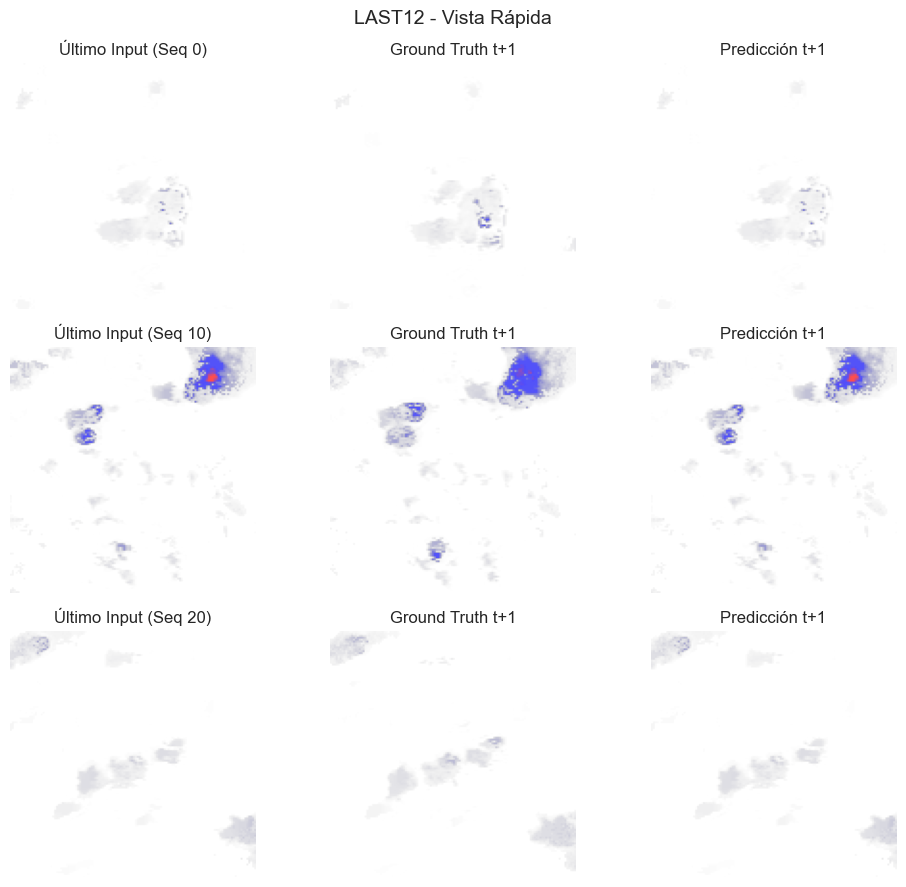

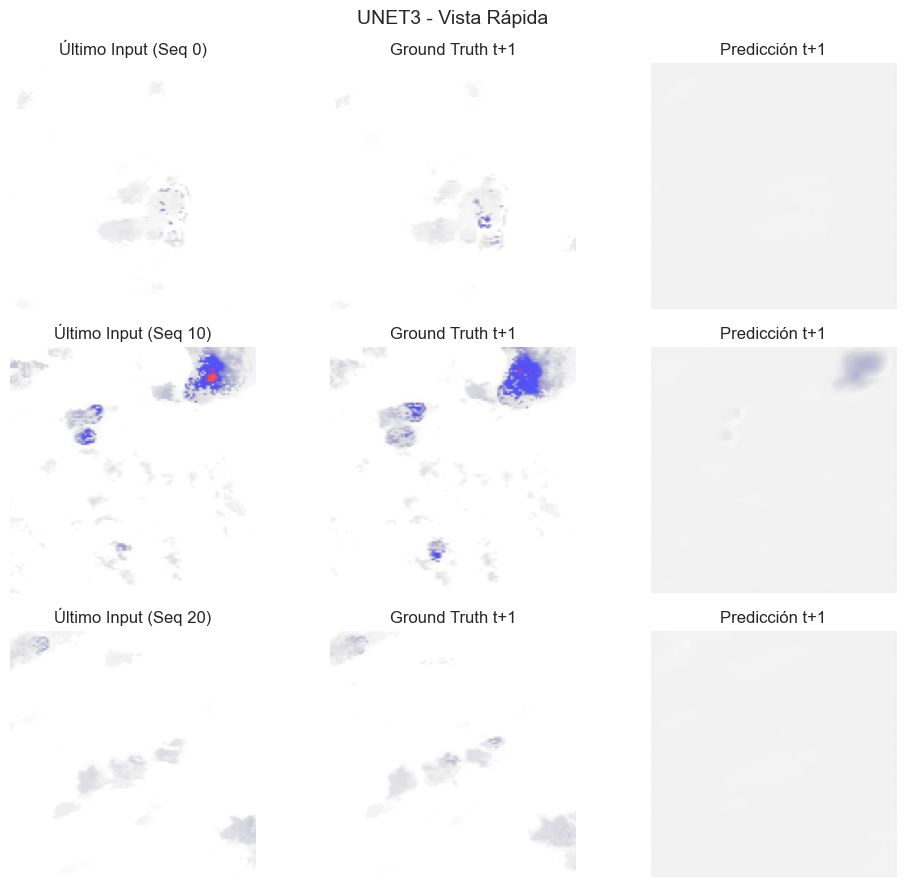

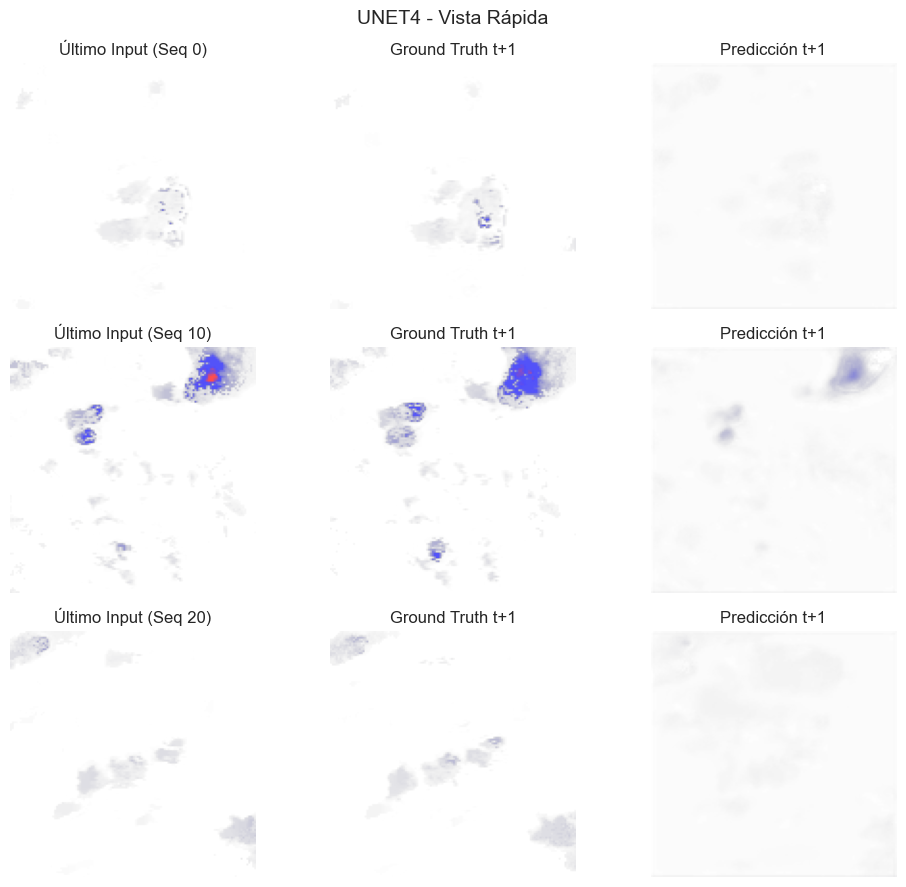

In [54]:
# Ver estadísticas generales
print("📊 RESUMEN DE RESULTADOS")
print("=" * 50)

for model_name in results.keys():
    data = results[model_name]
    print(f"\n{model_name.upper()}:")
    print(f"  Secuencias totales: {data['inputs'].shape[0]}")
    print(f"  Métricas:")
    for metric, value in data['metrics'].items():
        print(f"    - {metric.upper()}: {value:.4f}")
    
    # Error promedio global
    all_errors = np.abs(data['predictions'] - data['targets'])
    print(f"  MAE global: {np.mean(all_errors):.2f}")
    print(f"  Max error: {np.max(all_errors):.2f}")

# Visualizar múltiples secuencias rápidamente
def quick_view(model_name, sequences=[0, 5, 10]):
    """Vista rápida de múltiples secuencias"""
    data = results[model_name]
    n_seq = len(sequences)
    
    fig, axes = plt.subplots(n_seq, 3, figsize=(10, 3*n_seq))
    if n_seq == 1:
        axes = axes.reshape(1, -1)
    
    colors = [(0, 0, 0, 0), (0, 0, 1, 0.7), (1, 0, 0, 0.7)]
    cmap = mcolors.LinearSegmentedColormap.from_list("rain", list(zip([0, 0.5, 1], colors)))
    
    for row, seq_idx in enumerate(sequences):
        # Último input
        axes[row, 0].imshow(data['inputs'][seq_idx, -1]*100, cmap=cmap, vmin=0, vmax=100)
        axes[row, 0].set_title(f'Último Input (Seq {seq_idx})')
        axes[row, 0].axis('off')
        
        # Primer target
        axes[row, 1].imshow(data['targets'][seq_idx, 0]*100, cmap=cmap, vmin=0, vmax=100)
        axes[row, 1].set_title('Ground Truth t+1')
        axes[row, 1].axis('off')
        
        # Primera predicción
        axes[row, 2].imshow(data['predictions'][seq_idx, 0], cmap=cmap, vmin=0, vmax=100)
        axes[row, 2].set_title('Predicción t+1')
        axes[row, 2].axis('off')
    
    plt.suptitle(f'{model_name.upper()} - Vista Rápida', fontsize=14)
    plt.tight_layout()
    plt.show()

# Ver múltiples secuencias de cada modelo
for model in results.keys():
    quick_view(model, sequences=[0, 10, 20])